In [227]:
import pandas as pd
import glob
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or svg
%matplotlib inline

sns.set(context='notebook', style='whitegrid', font_scale=1.2)

Part 1: Import web-scraped csv's, clean/merge data, and have one ending df to use for regression

In [166]:
nba_box = pd.concat(
    map(pd.read_csv, ['data/nba_box_2018.csv', 'data/nba_box_2019.csv',
                     'data/nba_box_2020.csv','data/nba_box_2021.csv']), ignore_index=True)

nba_box

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,YEAR
0,Álex Abrines,SG,24,OKC,75,8,15.1,1.5,3.9,0.395,...,0.3,1.2,1.5,0.4,0.5,0.1,0.3,1.7,4.7,2018
1,Quincy Acy,PF,27,BRK,70,8,19.4,1.9,5.2,0.356,...,0.6,3.1,3.7,0.8,0.5,0.4,0.9,2.1,5.9,2018
2,Steven Adams,C,24,OKC,76,76,32.7,5.9,9.4,0.629,...,5.1,4.0,9.0,1.2,1.2,1.0,1.7,2.8,13.9,2018
3,Bam Adebayo,C,20,MIA,69,19,19.8,2.5,4.9,0.512,...,1.7,3.8,5.5,1.5,0.5,0.6,1.0,2.0,6.9,2018
4,Arron Afflalo,SG,32,ORL,53,3,12.9,1.2,3.1,0.401,...,0.1,1.2,1.2,0.6,0.1,0.2,0.4,1.1,3.4,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2723,Delon Wright,PG,28,SAC,27,8,25.8,3.9,8.3,0.462,...,1.0,2.9,3.9,3.6,1.6,0.4,1.3,1.1,10.0,2021
2724,Thaddeus Young,PF,32,CHI,68,23,24.3,5.4,9.7,0.559,...,2.5,3.8,6.2,4.3,1.1,0.6,2.0,2.2,12.1,2021
2725,Trae Young,PG,22,ATL,63,63,33.7,7.7,17.7,0.438,...,0.6,3.3,3.9,9.4,0.8,0.2,4.1,1.8,25.3,2021
2726,Cody Zeller,C,28,CHO,48,21,20.9,3.8,6.8,0.559,...,2.5,4.4,6.8,1.8,0.6,0.4,1.1,2.5,9.4,2021


In [167]:
nba_per100 = pd.concat(
    map(pd.read_csv, ['data/nba_per100_2018.csv', 'data/nba_per100_2019.csv',
                     'data/nba_per100_2020.csv','data/nba_per100_2021.csv']), ignore_index=True)
nba_per100

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,YEAR
0,Álex Abrines,SG,24,OKC,75,8,1134,5.0,12.7,0.395,...,5.0,1.2,1.7,0.4,1.1,5.4,15.4,116.0,110,2018
1,Quincy Acy,PF,27,BRK,70,8,1359,4.6,13.0,0.356,...,9.2,2.0,1.2,1.0,2.1,5.3,14.7,99.0,110,2018
2,Steven Adams,C,24,OKC,76,76,2487,8.9,14.2,0.629,...,13.7,1.8,1.8,1.6,2.6,4.3,21.1,125.0,107,2018
3,Bam Adebayo,C,20,MIA,69,19,1368,6.4,12.5,0.512,...,14.0,3.7,1.2,1.5,2.4,5.1,17.5,116.0,105,2018
4,Arron Afflalo,SG,32,ORL,53,3,682,4.7,11.6,0.401,...,4.7,2.2,0.3,0.6,1.5,4.0,12.8,98.0,115,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2723,Delon Wright,PG,28,SAC,27,8,696,7.2,15.5,0.462,...,7.2,6.7,3.0,0.8,2.4,2.1,18.7,115.0,115,2021
2724,Thaddeus Young,PF,32,CHI,68,23,1652,10.9,19.4,0.559,...,12.4,8.5,2.2,1.2,4.0,4.5,24.2,116.0,110,2021
2725,Trae Young,PG,22,ATL,63,63,2125,11.3,25.7,0.438,...,5.7,13.8,1.2,0.3,6.0,2.6,36.9,117.0,116,2021
2726,Cody Zeller,C,28,CHO,48,21,1005,8.8,15.7,0.559,...,15.9,4.2,1.3,0.8,2.5,5.9,21.9,123.0,112,2021


In [168]:
nba_per100_small = nba_per100[['ORtg','DRtg']]

In [169]:
nba_stats = nba_box.merge(nba_per100_small, how='inner', left_index=True, right_index=True)
nba_stats.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,TRB,AST,STL,BLK,TOV,PF,PTS,YEAR,ORtg,DRtg
0,Álex Abrines,SG,24,OKC,75,8,15.1,1.5,3.9,0.395,...,1.5,0.4,0.5,0.1,0.3,1.7,4.7,2018,116.0,110
1,Quincy Acy,PF,27,BRK,70,8,19.4,1.9,5.2,0.356,...,3.7,0.8,0.5,0.4,0.9,2.1,5.9,2018,99.0,110
2,Steven Adams,C,24,OKC,76,76,32.7,5.9,9.4,0.629,...,9.0,1.2,1.2,1.0,1.7,2.8,13.9,2018,125.0,107
3,Bam Adebayo,C,20,MIA,69,19,19.8,2.5,4.9,0.512,...,5.5,1.5,0.5,0.6,1.0,2.0,6.9,2018,116.0,105
4,Arron Afflalo,SG,32,ORL,53,3,12.9,1.2,3.1,0.401,...,1.2,0.6,0.1,0.2,0.4,1.1,3.4,2018,98.0,115


In [171]:
nba_salary = pd.concat(
    map(pd.read_csv, ['data/nba_salary_2018.csv', 'data/nba_salary_2019.csv',
                     'data/nba_salary_2020.csv','data/nba_salary_2021.csv']), ignore_index=True)
nba_salary.head(10)

,RK,NAME,TEAM,SALARY,YEAR
0,1,Stephen Curry,Golden State Warriors,37457154,2018
1,2,Blake Griffin,Detroit Pistons,32088932,2018
2,3,Paul Millsap,Denver Nuggets,31269231,2018
3,4,Kyle Lowry,Toronto Raptors,31200000,2018
4,5,Gordon Hayward,Boston Celtics,29727900,2018
5,6,Mike Conley,Memphis Grizzlies,28530608,2018
6,7,Russell Westbrook,Oklahoma City Thunder,28530608,2018
7,8,James Harden,Houston Rockets,28299399,2018
8,9,DeMar DeRozan,Toronto Raptors,27739975,2018
9,10,Al Horford,Boston Celtics,27734406,2018


In [172]:
#Combine nba stats with respective salaries
nba_merge = pd.merge(nba_stats, nba_salary,  how='left', left_on=['Player','YEAR'], right_on = ['NAME','YEAR'])

In [173]:
#Take out players that did not get mapped
nba_df = nba_merge[nba_merge['SALARY'].notnull()]

In [174]:
#Remove redundant or extraneous columns
nba_df = nba_df.drop(columns=['RK','NAME','TEAM'])

In [175]:
nba_df.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'YEAR', 'ORtg',
       'DRtg', 'SALARY'],
      dtype='object')

In [176]:
#Obtain salary cap and scaling factor to get all Y values in 2021 terms
salary_cap = pd.read_csv('data/salary_cap.csv')
salary_cap['scale'] = salary_cap.iloc[36]['salary_cap'] / salary_cap['salary_cap']
salary_cap.head()

,year,salary_cap,scale
0,1985,3600000.0,30.316667
1,1986,4233000.0,25.783133
2,1987,4945000.0,22.070779
3,1988,6164000.0,17.706035
4,1989,7232000.0,15.091261


In [177]:
#Merge total salary cap and 2021 scaling factor to main dataframe
nba_df = pd.merge(nba_df, salary_cap,  how='left', left_on=['YEAR'], right_on = ['year'])
nba_df = nba_df.drop(columns='year')

In [184]:
#Apply scaling factor to salary to express player salaries in 2021 dollars
nba_df['SALARY_2021'] = nba_df['SALARY'] * nba_df['scale']
nba_df.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,TOV,PF,PTS,YEAR,ORtg,DRtg,SALARY,salary_cap,scale,SALARY_2021
0,Steven Adams,C,24,OKC,76,76,32.7,5.9,9.4,0.629,...,1.7,2.8,13.9,2018,125.0,107,22471910.0,99093000.0,1.10139,2.475033e+07
1,Bam Adebayo,C,20,MIA,69,19,19.8,2.5,4.9,0.512,...,1.0,2.0,6.9,2018,116.0,105,2955840.0,99093000.0,1.10139,3.255531e+06
2,Cole Aldrich,C,29,MIN,21,0,2.3,0.2,0.7,0.333,...,0.0,0.5,0.6,2018,85.0,107,7300000.0,99093000.0,1.10139,8.040144e+06
3,LaMarcus Aldridge,C,32,SAS,75,75,33.5,9.2,18.0,0.510,...,1.5,2.1,23.1,2018,118.0,105,21461010.0,99093000.0,1.10139,2.363693e+07
4,Jarrett Allen,C,19,BRK,72,31,20.0,3.3,5.5,0.589,...,1.1,2.0,8.2,2018,119.0,108,2034120.0,99093000.0,1.10139,2.240359e+06


In [185]:
nba_df.isna().sum()

Player           0
Pos              0
Age              0
Tm               0
G                0
GS               0
MP               0
FG               0
FGA              0
FG%              5
3P               0
3PA              0
3P%            110
2P               0
2PA              0
2P%             18
eFG%             5
FT               0
FTA              0
FT%             71
ORB              0
DRB              0
TRB              0
AST              0
STL              0
BLK              0
TOV              0
PF               0
PTS              0
YEAR             0
ORtg             4
DRtg             0
SALARY           0
salary_cap       0
scale            0
SALARY_2021      0
dtype: int64

Most of the fields with nulls apply to shooting percentages. In other words, players that have not attempted a shot will have null percentages. I'm going to drop these values as it only applies to a small subset of players with very little playing time

In [195]:
nba_df.dropna(subset=['FT%','eFG%','ORtg'],inplace=True)

In [199]:
#Check for duplicates, there are none
nba_df[nba_df.duplicated() == True]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,TOV,PF,PTS,YEAR,ORtg,DRtg,SALARY,salary_cap,scale,SALARY_2021


In [236]:
nba_df.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'YEAR', 'ORtg',
       'DRtg', 'SALARY', 'salary_cap', 'scale', 'SALARY_2021'],
      dtype='object')

This tool is meant to predict an NBA player's salary. Due to current salary cap and contract regulations, this analysis won't be appropriate for all players. A player's first deal, a rookie contract, is set in stone and superstar athletes have a max contract provision. To account for this, I will be flagging these players. For simplicity, I am assuming that rookies are under the age of 23 and max contract players are those whose salary is 25% of the cap or greater.

In [237]:
nba_df['rookie_flag'] = nba_df['Age'] < 23
nba_df['rookie_flag'] = nba_df2['rookie_flag'].astype(int)
nba_df[nba_df['rookie_flag'] == 0]

nba_df['max_flag'] = (nba_df['SALARY'] / nba_df['salary_cap']) > .25
nba_df['max_flag'] = nba_df['max_flag'].astype(int)
nba_df[(nba_df['max_flag'] == 0) & (nba_df['rookie_flag'] == 0)]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,PTS,YEAR,ORtg,DRtg,SALARY,salary_cap,scale,SALARY_2021,rookie_flag,max_flag
0,Steven Adams,C,24,OKC,76,76,32.7,5.9,9.4,0.629,...,13.9,2018,125.0,107,22471910.0,99093000.0,1.10139,2.475033e+07,0,0
2,Cole Aldrich,C,29,MIN,21,0,2.3,0.2,0.7,0.333,...,0.6,2018,85.0,107,7300000.0,99093000.0,1.10139,8.040144e+06,0,0
3,LaMarcus Aldridge,C,32,SAS,75,75,33.5,9.2,18.0,0.510,...,23.1,2018,118.0,105,21461010.0,99093000.0,1.10139,2.363693e+07,0,0
5,Tony Allen,SF,36,NOP,22,0,12.4,2.0,4.1,0.484,...,4.7,2018,95.0,110,1471382.0,99093000.0,1.10139,1.620565e+06,0,0
6,Al-Farouq Aminu,PF,27,POR,69,67,30.0,3.3,8.4,0.395,...,9.3,2018,105.0,104,7319035.0,99093000.0,1.10139,8.061109e+06,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,Delon Wright,SG,28,DET,36,31,29.2,3.8,8.1,0.464,...,10.4,2021,119.0,111,9000000.0,109140000.0,1.00000,9.000000e+06,0,0
2097,Delon Wright,PG,28,SAC,27,8,25.8,3.9,8.3,0.462,...,10.0,2021,115.0,115,9000000.0,109140000.0,1.00000,9.000000e+06,0,0
2098,Thaddeus Young,PF,32,CHI,68,23,24.3,5.4,9.7,0.559,...,12.1,2021,116.0,110,13545000.0,109140000.0,1.00000,1.354500e+07,0,0
2100,Cody Zeller,C,28,CHO,48,21,20.9,3.8,6.8,0.559,...,9.4,2021,123.0,112,15415730.0,109140000.0,1.00000,1.541573e+07,0,0


Independent variables to use: Age, G, MP, FGA, 3P, eFG%, FTA, FT%, ORB, DRB, Pos_X, AST, STL, BLK, TOV, PF, PTS, ORtg, DRtg
Dependent variable: SALARY_2021_log. To prevent explosiveness and highly skewed results from large salary values, I will be taking the log of salary as the dependent variable

In [273]:
nba_df_small = nba_df[['Player','Age','G','MP','FGA','3P','eFG%','FTA','FT%','ORB','DRB',
                      'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS','YEAR','ORtg', 'DRtg','SALARY_2021',
                      'rookie_flag','max_flag']]
nba_df_small['SALARY_2021_log'] = np.log(nba_df_small['SALARY_2021'])
nba_df_small

/var/folders/75/fwf63z_j1jvf891tg0n68jn80000gn/T/ipykernel_52713/329394510.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_df_small['SALARY_2021_log'] = np.log(nba_df_small['SALARY_2021'])


,Player,Age,G,MP,FGA,3P,eFG%,FTA,FT%,ORB,...,TOV,PF,PTS,YEAR,ORtg,DRtg,SALARY_2021,rookie_flag,max_flag,SALARY_2021_log
0,Steven Adams,24,76,32.7,9.4,0.0,0.629,3.8,0.559,5.1,...,1.7,2.8,13.9,2018,125.0,107,2.475033e+07,0,0,17.024349
1,Bam Adebayo,20,69,19.8,4.9,0.0,0.512,2.6,0.721,1.7,...,1.0,2.0,6.9,2018,116.0,105,3.255531e+06,1,0,14.995866
2,Cole Aldrich,29,21,2.3,0.7,0.0,0.333,0.3,0.333,0.1,...,0.0,0.5,0.6,2018,85.0,107,8.040144e+06,0,0,15.899958
3,LaMarcus Aldridge,32,75,33.5,18.0,0.4,0.520,5.3,0.837,3.3,...,1.5,2.1,23.1,2018,118.0,105,2.363693e+07,0,0,16.978321
4,Jarrett Allen,19,72,20.0,5.5,0.1,0.596,2.0,0.776,2.0,...,1.1,2.0,8.2,2018,119.0,108,2.240359e+06,1,0,14.622147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2097,Delon Wright,28,27,25.8,8.3,1.2,0.536,1.3,0.833,1.0,...,1.3,1.1,10.0,2021,115.0,115,9.000000e+06,0,0,16.012735
2098,Thaddeus Young,32,68,24.3,9.7,0.2,0.568,1.7,0.628,2.5,...,2.0,2.2,12.1,2021,116.0,110,1.354500e+07,0,0,16.421528
2099,Trae Young,22,63,33.7,17.7,2.2,0.499,8.7,0.886,0.6,...,4.1,1.8,25.3,2021,117.0,116,6.571800e+06,1,0,15.698298
2100,Cody Zeller,28,48,20.9,6.8,0.1,0.565,2.5,0.714,2.5,...,1.1,2.5,9.4,2021,123.0,112,1.541573e+07,0,0,16.550899


In [343]:
#upper = np.triu(nba_df_small.corr()) 
#sns.heatmap(nba_df_small.corr(), cmap="seismic_r", vmin=-1, vmax=1, mask=upper);
nba_df_small.corr()

,Age,G,MP,FGA,3P,eFG%,FTA,FT%,ORB,DRB,...,PF,PTS,YEAR,ORtg,DRtg,SALARY_2021,rookie_flag,max_flag,SALARY_2021_log,predicted_salary
Age,1.000000,-0.002519,0.101900,0.035197,0.137510,0.075025,0.015410,0.128760,-0.039128,0.067075,...,0.027045,0.044423,-0.022082,0.115583,-0.026494,0.305089,-0.649617,0.161958,0.227981,0.260486
G,-0.002519,1.000000,0.477786,0.363842,0.275894,0.260450,0.257319,0.116283,0.210556,0.335690,...,0.317295,0.377645,-0.181046,0.269297,-0.112693,0.222301,0.014189,0.105167,0.347405,0.616608
MP,0.101900,0.477786,1.000000,0.875869,0.646779,0.188081,0.683045,0.245646,0.319526,0.659118,...,0.659864,0.862212,-0.002841,0.225802,0.071191,0.569510,-0.111039,0.313333,0.540223,0.872386
FGA,0.035197,0.363842,0.875869,1.000000,0.706455,0.093484,0.806334,0.284337,0.211035,0.573477,...,0.503460,0.979202,0.004786,0.129514,0.081433,0.606211,-0.073343,0.420446,0.514535,0.774369
3P,0.137510,0.275894,0.646779,0.706455,1.000000,0.104425,0.373157,0.393374,-0.247068,0.196850,...,0.244653,0.671804,0.064275,0.088031,0.248592,0.405997,-0.128342,0.287822,0.354417,0.509365
eFG%,0.075025,0.260450,0.188081,0.093484,0.104425,1.000000,0.120417,0.001339,0.333810,0.281466,...,0.243598,0.209266,0.083457,0.779192,-0.165938,0.086451,-0.091236,0.046161,0.105377,0.151744
FTA,0.015410,0.257319,0.683045,0.806334,0.373157,0.120417,1.000000,0.156886,0.381422,0.624946,...,0.474241,0.871925,-0.000510,0.234031,-0.069978,0.588565,-0.048222,0.452788,0.441448,0.626002
FT%,0.128760,0.116283,0.245646,0.284337,0.393374,0.001339,0.156886,1.000000,-0.212997,-0.003787,...,0.007956,0.286897,0.034047,0.187300,0.235583,0.143885,-0.113481,0.110936,0.123774,0.143358
ORB,-0.039128,0.210556,0.319526,0.211035,-0.247068,0.333810,0.381422,-0.212997,1.000000,0.703916,...,0.512916,0.285927,0.014116,0.380260,-0.341067,0.222341,0.010871,0.082098,0.199708,0.342302
DRB,0.067075,0.335690,0.659118,0.573477,0.196850,0.281466,0.624946,-0.003787,0.703916,1.000000,...,0.635910,0.624641,0.028885,0.282281,-0.330812,0.502600,-0.062112,0.291278,0.432949,0.679503


In [311]:
#Baseline regression
nba_filtered = nba_df_small[(nba_df_small['max_flag'] == 0) & (nba_df_small['rookie_flag'] == 0)]
X = nba_filtered.drop(columns = ['SALARY_2021','max_flag','rookie_flag','Player','SALARY_2021_log',
                                'predicted_salary'])
#X = sm.add_constant(X)
y = nba_filtered['SALARY_2021_log']

model = sm.OLS(y,X)
nba_model = model.fit()
nba_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        SALARY_2021_log   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          1.406e+04
Date:                Sun, 05 Sep 2021   Prob (F-statistic):                        0.00
Time:                        14:50:36   Log-Likelihood:                         -2323.6
No. Observations:                1508   AIC:                                      4685.
Df Residuals:                    1489   BIC:                                      4786.
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Age            0.0615      0.009      7.224      0.000       0.045       0.078
G              0.0108      0.002      7.077      0.000       0.008       0.014
MP             0.0469      0.012      3.858      0.000       0.023       0.071
FGA           -0.1039      0.066     -1.581      0.114      -0.233       0.025
3P            -0.0947      0.082     -1.150      0.250      -0.256       0.067
eFG%          -0.2632      0.911     -0.289      0.773      -2.049       1.523
FTA           -0.0978      0.069     -1.415      0.157      -0.233       0.038
FT%           -0.2316      0.281     -0.824      0.410      -0.783       0.320
ORB           -0.1136      0.086     -1.326      0.185      -0.282       0.054
DRB            0.1007      0.036      2.837      0.005       0.031       0.170
AST           -0.0792      0.047     -1.689      0.091      -0.171       0.013
STL            0.3007      0.118      2.541      0.011       0.069       0.533
BLK            0.2539      0.111      2.282      0.023       0.036       0.472
TOV            0.3411      0.137      2.489      0.013       0.072       0.610
PF            -0.2631      0.067     -3.911      0.000      -0.395      -0.131
PTS            0.1175      0.061      1.920      0.055      -0.003       0.237
YEAR           0.0055      0.001      8.992      0.000       0.004       0.007
ORtg          -0.0075      0.006     -1.204      0.229      -0.020       0.005
DRtg           0.0149      0.010      1.476      0.140      -0.005       0.035
==============================================================================
Omnibus:                      263.618   Durbin-Watson:                   1.446
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              583.291
Skew:                          -0.989   Prob(JB):                    2.19e-127
Kurtosis:                       5.318   Cond. No.                     6.38e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [312]:
nba_df_small['predicted_salary'] = nba_model.predict(X)

/var/folders/75/fwf63z_j1jvf891tg0n68jn80000gn/T/ipykernel_52713/2003706368.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_df_small['predicted_salary'] = nba_model.predict(X)


In [313]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))

    pred = x

    plt.subplot(1, 3, 1)
    plt.scatter(x,y, alpha=0.5)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res, alpha=0.5)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot");

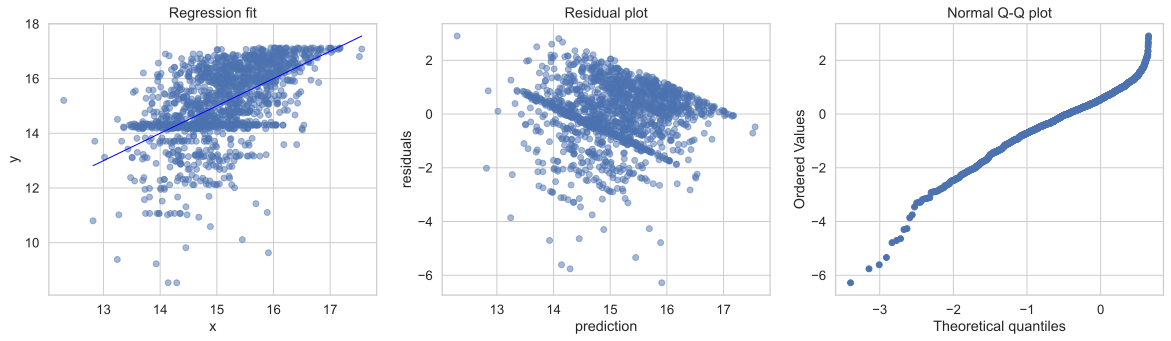

In [321]:
#Initial diagnostic plot
diagnostic_plot(nba_df_small['predicted_salary'], nba_df_small['SALARY_2021_log'])
plt.savefig('mvp_plot.png')

Check for Outliers and Multicollinearity

In [318]:
#Check for influential data points
#There are no influential data points in this analysis, as the maximum is less than 0.5
influence = nba_model.get_influence()
influence_frame = influence.summary_frame().reset_index()
influence_frame['cooks_d'].max()

0.11652885058709953

In [316]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif(df_X):
    '''
    Calculate the VIF for each feature of df_X (a Pandas DataFrame).
    '''
    vif_data = [variance_inflation_factor(df_X.values, i)
                for i in range(df_X.shape[1])]
    
    return pd.Series(vif_data, index=df_X.columns)

In [350]:
test = X.drop(columns=['YEAR','ORtg','FGA','MP','FTA','3P','TOV','Age'])
vif(test)
#vif(X)
#The variables I took out all have high correlation to points per game or have high standalone VIF
#Although DRtg has a high VIF, it has low correlation to all other variables

G        5.969743
eFG%    51.048249
FT%     42.200309
ORB      6.039206
DRB     13.548562
AST      5.568316
STL      7.076296
BLK      4.350116
PF      15.523331
PTS     10.116101
DRtg    79.544464
dtype: float64

In [355]:
#Regression after VIF adjustments
nba_filtered = nba_df_small[(nba_df_small['max_flag'] == 0) & (nba_df_small['rookie_flag'] == 0)]
X2 = nba_filtered.drop(columns = ['SALARY_2021','max_flag','rookie_flag','Player','SALARY_2021_log',
                                'predicted_salary','YEAR','ORtg','FGA','MP','FTA','3P','TOV','Age'])
#X = sm.add_constant(X)
y2 = nba_filtered['SALARY_2021_log']

model = sm.OLS(y2,X2)
nba_model = model.fit()
nba_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        SALARY_2021_log   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          2.156e+04
Date:                Sun, 05 Sep 2021   Prob (F-statistic):                        0.00
Time:                        16:59:08   Log-Likelihood:                         -2417.0
No. Observations:                1508   AIC:                                      4856.
Df Residuals:                    1497   BIC:                                      4914.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
G              0.0134      0.001      8.951      0.000       0.010       0.016
eFG%           0.5492      0.423      1.299      0.194      -0.280       1.378
FT%            0.0338      0.264      0.128      0.898      -0.484       0.552
ORB           -0.1590      0.067     -2.363      0.018      -0.291      -0.027
DRB            0.2558      0.034      7.506      0.000       0.189       0.323
AST            0.0062      0.030      0.210      0.834      -0.052       0.064
STL            0.7641      0.105      7.288      0.000       0.558       0.970
BLK            0.6073      0.112      5.422      0.000       0.388       0.827
PF            -0.1716      0.063     -2.716      0.007      -0.296      -0.048
PTS            0.0119      0.010      1.240      0.215      -0.007       0.031
DRtg           0.1172      0.002     46.978      0.000       0.112       0.122
==============================================================================
Omnibus:                      132.735   Durbin-Watson:                   1.446
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              201.974
Skew:                          -0.661   Prob(JB):                     1.39e-44
Kurtosis:                       4.211   Cond. No.                     1.64e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""